In [1]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate, NBEATSx
from neuralforecast.losses.pytorch import MSE, MAE, MAPE
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [18]:
# Functions

def createLag(data, amt=10):
    """
    Create a lag inside dataframe, in business days

    Input:
        data -> Pandas dataframe 
        amt -> int

    Output:
        Copy of pandas Dataframe
    """
    if 'ds' in data:
        copy = data.copy()
        copy['ds'] = copy['ds'] + pd.tseries.offsets.BusinessDay(amt)
        return copy
    else:
        print(f"No 'ds' column found inside dataframe")
        return data

def trainTestValSplit(data, test_size, val_size):
    """
    Splits data into train-test-validation sets

    Input:
        data -> Pandas dataframe
        test_size -> Proportion of data for test set
        val_size -> Proportiion of data fro validation set

    Output:
        This is not needed yet, actually
    """
    pass

def scaleStandard(df_col):
    """
    Fits and returns a standard scaled version of a dataframe column
    """
    scaler = StandardScaler()
    df_col = scaler.fit_transform(df_col)
    df_col = pd.DataFrame(df_col)
    return df_col, scaler

def logReturn(data, df_col):
    """
    Perform log return for a dataframe column
    """
    new_col = np.log1p(data[df_col].pct_change())
    return new_col

def transformData(data, log_return = [], standard_scale = []):
    """
    Perform essential transformations towards the dataframe
    """
    y_log_ret = False
    y_std_scale = False

    data.sort_values(by='ds', inplace=True)

    if len(log_return) > 0:
        
        for col1 in log_return:
            try:
                #print(data[col1])
                data[col1] = logReturn(data, col1)
            except Exception as e:
                print(e)
                pass
            
        if 'y' in log_return:
            y_log_ret = True

    if len(standard_scale) > 0:
        
        for col2 in standard_scale:
            try:
                data[col2], _ = scaleStandard(data[[col2]])
            except Exception as e:
                print(e)
                pass
            
        if 'y' in standard_scale:
            data['y'], yScaler = scaleStandard(data[['y']])
            y_std_scale = True

    return data

In [19]:
# Exogenous 

Y_df = pd.read_csv(os.path.join('dataset', 'DatedBrent', 'priceForecast_nosent_1.csv')
                  ).rename({'date' : 'ds', 'BrDa' : 'y'}, axis=1
                          ).drop(columns=['Unnamed: 0'])
Y_df['unique_id'] = 'Dated'
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# We make validation and test splits
n_time = len(Y_df.ds.unique())
val_size = int(.025 * n_time)
test_size = int(.025 * n_time)

print(f'Total length is {n_time}, with validation and test size of {val_size} for each')

Total length is 1962, with validation and test size of 49 for each


In [20]:
Y_df

ds   BrFu     Gas        OVX         DXY        GPRD        y  \
0    2024-08-02  73.52  2.3176  33.419998  103.209999  207.799438   78.265   
1    2024-08-01  76.93  2.3980  33.689999  104.419998  139.878098   81.825   
2    2024-07-31  77.91  2.4425  31.490000  104.099998  135.206848   81.450   
3    2024-07-30  74.73  2.3443  30.820000  104.550003   95.696396   79.140   
4    2024-07-26  77.16  2.4170  26.490000  104.320000  105.654129   81.245   
...         ...    ...     ...        ...         ...         ...      ...   
1957 2014-08-15  97.35  2.5750  17.860001   81.419998  131.822342  100.775   
1958 2014-08-14  95.58  2.5403  17.190001   81.589996  106.742241  100.445   
1959 2014-08-13  97.59  2.6266  17.549999   81.599998  165.846603  101.855   
1960 2014-08-12  97.37  2.6045  17.540001   81.500000  150.571259  101.725   
1961 2014-08-08  97.65  2.7537  18.850000   81.389999  212.396439  103.315   

     unique_id  
0        Dated  
1        Dated  
2        Dated  
3        Dated  
4        Dated  
...        ...  
1957     Dated  
1958     Dated  
1959     Dated  
1960     Dated  
1961     Dated  

[1962 rows x 8 columns]

In [21]:
Y_df_test = Y_df.copy().rename({'y' : 'BrDa'}, axis=1)
Y_df_test = createLag(Y_df_test, amt=30)
df = Y_df[['ds', 'y']].merge(Y_df_test, on = 'ds')
df

ds       y   BrFu     Gas        OVX         DXY        GPRD  \
0    2024-08-02  78.265  80.73  2.4966  24.230000  105.800003  128.757050   
1    2024-07-30  79.140  81.57  2.4652  24.170000  105.260002  144.024689   
2    2024-07-26  81.245  78.45  2.3877  24.450001  105.550003   90.600143   
3    2024-07-25  82.655  78.62  2.4020  24.799999  105.199997  134.210846   
4    2024-07-24  82.995  78.50  2.3944  25.540001  104.650002  118.305992   
...         ...     ...    ...     ...        ...         ...         ...   
1812 2014-09-26  95.250  97.35  2.5750  17.860001   81.419998  131.822342   
1813 2014-09-25  95.465  95.58  2.5403  17.190001   81.589996  106.742241   
1814 2014-09-24  94.585  97.59  2.6266  17.549999   81.599998  165.846603   
1815 2014-09-23  95.065  97.37  2.6045  17.540001   81.500000  150.571259   
1816 2014-09-19  96.645  97.65  2.7537  18.850000   81.389999  212.396439   

         BrDa unique_id  
0      87.015     Dated  
1      85.280     Dated  
2      81.730     Dated  
3      81.640     Dated  
4      81.245     Dated  
...       ...       ...  
1812  100.775     Dated  
1813  100.445     Dated  
1814  101.855     Dated  
1815  101.725     Dated  
1816  103.315     Dated  

[1817 rows x 9 columns]

In [22]:
test_data = transformData(df,
                         log_return = ['BrFu', 'Gas', 'DXY', 'BrDa'],
                         standard_scale = ['y'])
test_data.dropna(inplace=True)
test_data

ds         y      BrFu       Gas        OVX       DXY  \
1815 2014-09-23  1.448573 -0.002872 -0.055705  17.540001  0.001351   
1814 2014-09-24  1.424494  0.002257  0.008450  17.549999  0.001226   
1813 2014-09-25  1.468639 -0.020811 -0.033408  17.190001 -0.000123   
1812 2014-09-26  1.457854  0.018349  0.013567  17.860001 -0.002086   
1811 2014-09-30  1.435279 -0.029925 -0.004437  19.520000  0.005634   
...         ...       ...       ...       ...        ...       ...   
4    2024-07-24  0.843081  0.007673 -0.006038  25.540001 -0.005527   
3    2024-07-25  0.826024  0.001527  0.003169  24.799999  0.005242   
2    2024-07-26  0.755292 -0.002165 -0.005971  24.450001  0.003322   
1    2024-07-30  0.649694  0.039000  0.031942  24.170000 -0.002751   
0    2024-08-02  0.605800 -0.010351  0.012657  24.230000  0.005117   

            GPRD      BrDa unique_id  
1815  150.571259 -0.015509     Dated  
1814  165.846603  0.001277     Dated  
1813  106.742241 -0.013940     Dated  
1812  131.822342  0.003280     Dated  
1811  216.154495 -0.010825     Dated  
...          ...       ...       ...  
4     118.305992  0.006235     Dated  
3     134.210846  0.004850     Dated  
2      90.600143  0.001102     Dated  
1     144.024689  0.042519     Dated  
0     128.757050  0.020141     Dated  

[1816 rows x 9 columns]

---

In [23]:
horizon = 30
input_size = 30*2
models = [
    TSMixer(h=horizon,
                input_size=input_size,
                n_series=1,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='identity',
                loss=MAPE(),
                valid_loss=MAPE(),
                random_seed=12345678,
                ),
    TSMixerx(h=horizon,
                input_size=input_size,
                n_series=1,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='identity',
                dropout=0.7,
                loss=MAPE(),
                valid_loss=MAPE(),
                random_seed=12345678,
                futr_exog_list=['Gas', 'DXY', 'BrFu', 'BrDa'],
                ),
    NBEATSx(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=5,
                scaler_type='identity',
                loss=MAPE(),
                valid_loss=MAPE(),
                random_seed=12345678,
                futr_exog_list=['Gas', 'DXY', 'BrFu', 'BrDa']
                ),
]

Seed set to 12345678
Seed set to 12345678
Seed set to 12345678


In [24]:
nf = NeuralForecast(
    models=models,
    freq='D')

In [25]:
Y_hat_df = nf.cross_validation(df=df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None
                               )
Y_hat_df = Y_hat_df.reset_index()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | loss          | MAPE                     | 0      | train
1 | valid_loss    | MAPE                     | 0      | train
2 | padder        | ConstantPad1d            | 0      | train
3 | scaler        | TemporalNorm             | 0      | train
4 | norm          | ReversibleInstanceNorm1d | 2      | train
5 | mixing_layers | Sequential               | 8.2 K  | train
6 | out           | Linear                   | 1.8 K  | train
-------------------------------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type                     | Params | Mode 
--------------------------------------------------------------------------
0  | loss                | MAPE                     | 0      | train
1  | valid_loss          | MAPE                     | 0      | train
2  | padder              | ConstantPad1d            | 0      | train
3  | scaler              | TemporalNorm             | 0      | train
4  | norm                | ReversibleInstanceNorm1d | 2      | train
5  | temporal_projection | Linear                   | 1.8 K  | train
6  | feature_mixer_hist  | FeatureMixing            | 8.8 K  | train
7  | feature_mixer_futr  | FeatureMixing            | 8.6 K  | train
8  | first_mixing        | MixingLayer              | 33.1 K | train
9  | mixing_block        | Sequential               | 33.9 K | train
10 | ou

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.9 M  | train
-------------------------------------------------------
2.9 M     Trainable params
3.7 K     Non-trainable params
2.9 M     Total params
11.509    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

e:\VM\miniconda3\envs\pytorch\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [26]:
# Y_hat_df['y'] = yScaler.inverse_transform(Y_hat_df[['y']])
# Y_hat_df['TSMixer'] = yScaler.inverse_transform(Y_hat_df[['TSMixer']])
# Y_hat_df['TSMixerx'] = yScaler.inverse_transform(Y_hat_df[['TSMixerx']])
# Y_hat_df['NBEATSx'] = yScaler.inverse_transform(Y_hat_df[['NBEATSx']])

In [27]:
Y_hat_df

unique_id         ds     cutoff   TSMixer  TSMixerx   NBEATSx         y
0       Dated 2024-04-10 2024-04-09  1.177287  1.390748  1.221220  1.254183
1       Dated 2024-04-11 2024-04-09  1.155755  1.350257  1.241936  1.285286
2       Dated 2024-04-12 2024-04-09  1.223631  1.333797  1.155751  1.362289
3       Dated 2024-04-16 2024-04-09  1.191017  1.371189  1.099887  1.259200
4       Dated 2024-04-17 2024-04-09  1.183228  1.362661  1.161999  1.177431
..        ...        ...        ...       ...       ...       ...       ...
595     Dated 2024-07-24 2024-05-21  1.090267  0.998137  0.934902  0.843081
596     Dated 2024-07-25 2024-05-21  1.089488  0.950186  0.956440  0.826024
597     Dated 2024-07-26 2024-05-21  0.982749  1.021258  0.885282  0.755292
598     Dated 2024-07-30 2024-05-21  1.083079  0.930227  0.883445  0.649694
599     Dated 2024-08-02 2024-05-21  1.033108  0.968054  0.857022  0.605800

[600 rows x 7 columns]

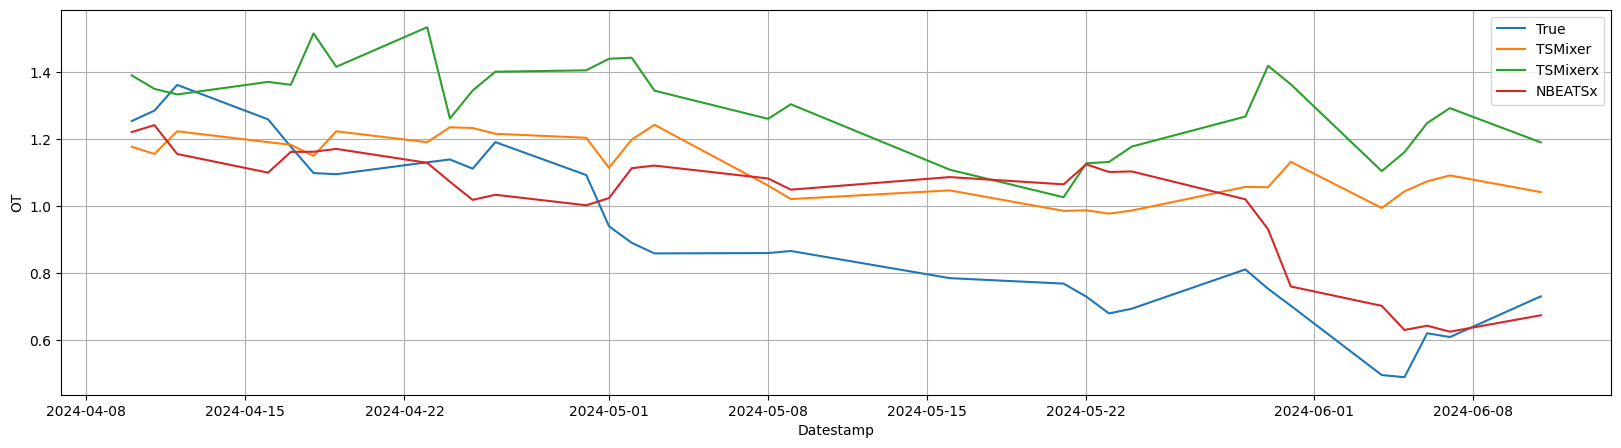

In [30]:
import matplotlib.pyplot as plt
Y_plot = Y_hat_df[Y_hat_df['unique_id']=='Dated']
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
for model in models:
    plt.plot(Y_plot['ds'], Y_plot[f'{model}'], label=f'{model}')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

In [29]:
from neuralforecast.losses.numpy import mse, mae, mape

for model in models:
    mae_model = mae(Y_hat_df['y'], Y_hat_df[f'{model}']) 
    mse_model = mse(Y_hat_df['y'], Y_hat_df[f'{model}'])
    mape_model = mape(Y_hat_df['y'], Y_hat_df[f'{model}'])
    print(f'{model} horizon {horizon} - MAE: {mae_model:.3f}')
    print(f'{model} horizon {horizon} - MSE: {mse_model:.3f}')
    print(f'{model} horizon {horizon} - MAPE: {mape_model:.3f}')

TSMixer horizon 30 - MAE: 0.259
TSMixer horizon 30 - MSE: 0.092
TSMixer horizon 30 - MAPE: 0.363
TSMixerx horizon 30 - MAE: 0.274
TSMixerx horizon 30 - MSE: 0.113
TSMixerx horizon 30 - MAPE: 0.367
NBEATSx horizon 30 - MAE: 0.195
NBEATSx horizon 30 - MSE: 0.067
NBEATSx horizon 30 - MAPE: 0.234


In [14]:
# import matplotlib.pyplot as plt
# Y_plot = Y_hat_df[Y_hat_df['unique_id']=='Future']
# cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
# Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

# plt.figure(figsize=(20,5))
# plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
# for model in models:
#     plt.plot(Y_plot['ds'], Y_plot[f'{model}'], label=f'{model}')
# plt.xlabel('Datestamp')
# plt.ylabel('OT')
# plt.grid()
# plt.legend()